# 그래프에 조건/반복 설정하기

## 1. 조건에 따른 반복 설정하기

In [ ]:
from typing import Annotated
from typing_extensions import TypedDict
from operator import add

class State(TypedDict):
    aggregates: Annotated[list[str], add]

In [2]:
def node_a(state:State):
    return {
        "aggregates" : ["A"]
    }

def node_b(state: State):
    return {
        "aggregates" : ["B"]
    }

In [3]:
def should_continue(state: State):
    if len(state['aggregates']) < 7:
        return "b"
    else:
        return "end"

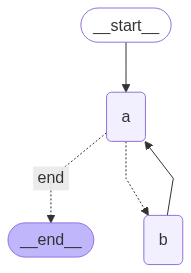

In [4]:
from langgraph.graph import StateGraph, START, END

workflow = StateGraph(State)

workflow.add_node("a", node_a)
workflow.add_node("b", node_b)

workflow.add_edge(START, "a")
workflow.add_conditional_edges(
    "a",
    should_continue,
    {
        "b" : "b",
        "end" : END
    }
)
workflow.add_edge("b", "a")

app = workflow.compile()

app

In [6]:
app.invoke({})

{'aggregates': ['A', 'B', 'A', 'B', 'A', 'B', 'A']}

## 2. 사용자 입력에 따른 반복 조건 설정하기

In [7]:
from typing import Annotated
from typing_extensions import TypedDict
from langchain_core.messages import (
    HumanMessage,
    AIMessage,
    AnyMessage
)
from langgraph.graph.message import add_messages

# define state
class State(TypedDict):
    recursion_num: int
    messages: Annotated[list[AnyMessage], add_messages]

# define nodes
def user_input_node(state: State):
    recursion_num = state['recursion_num']
    query = input(f"'반복'/'종료' 중 하나를 입력하세요 (현재 반복 횟수: {recursion_num}) > ")
    user_message = HumanMessage(content=query)

    return {
        'recursion_num' : recursion_num,
        'messages' : [user_message]
    }

def ai_answer_node(state: State):
    recursion_num = state['recursion_num']
    answer = f"{recursion_num}번째 답변!"
    ai_message = AIMessage(content=answer)

    return {
        'recursion_num' : recursion_num + 1,
        'messages' : [ai_message]
    }

# define conditional routing function
def should_continue(state: State):
    if state['messages'][-1].content == "반복":
        return "ai"
    else:
        return "END"

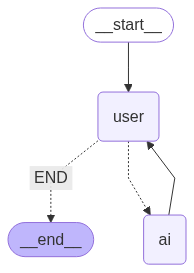

In [8]:
from langgraph.graph import StateGraph, START, END

workflow = StateGraph(State)

workflow.add_node("user", user_input_node)
workflow.add_node("ai", ai_answer_node)

workflow.add_edge(START, "user")
workflow.add_conditional_edges(
    "user",
    should_continue,
    {
        "ai" : "ai",
        "END" : END
    }
)
workflow.add_edge("ai", "user")

app = workflow.compile()

app

In [13]:
for chunk in app.stream({"recursion_num" : 0}, stream_mode="updates"):
    for node, value in chunk.items():
        print(node)
        if "messages" in value:
            print(value['messages'])

user
[HumanMessage(content='반복', additional_kwargs={}, response_metadata={}, id='8bd5078d-143d-4e05-89e2-80f136d4a07a')]
ai
[AIMessage(content='0번째 답변!', additional_kwargs={}, response_metadata={}, id='ae2de0c1-f00e-4489-b830-3a39c6b9d585')]
user
[HumanMessage(content='반복', additional_kwargs={}, response_metadata={}, id='c9c5a517-3198-4e9c-9e27-5c0cc1ea5948')]
ai
[AIMessage(content='1번째 답변!', additional_kwargs={}, response_metadata={}, id='216bf777-f5ac-41ee-96df-4ab93ced603e')]
user
[HumanMessage(content='반복', additional_kwargs={}, response_metadata={}, id='b61ff1b3-52ef-4fee-bc37-7c14467c298b')]
ai
[AIMessage(content='2번째 답변!', additional_kwargs={}, response_metadata={}, id='7115ad98-7fac-4a34-a0bd-6c52f2cb41d3')]
user
[HumanMessage(content='반복', additional_kwargs={}, response_metadata={}, id='30b47758-1965-494e-b4f3-a632527c0d3e')]
ai
[AIMessage(content='3번째 답변!', additional_kwargs={}, response_metadata={}, id='bd4bc838-2d2b-491f-b3e1-179c41634986')]
user
[HumanMessage(content='반복',